In [55]:
from sklearn.preprocessing import MinMaxScaler  # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
import pandas as pd  
import numpy as np  

scaler = MinMaxScaler()
monthly_events = pd.read_csv('./data/monthly_events.csv')
monthly_events['num_events'] = scaler.fit_transform(monthly_events[['num_events']])

# Create sequences for encoder-decoder
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out])
    return np.array(X), np.array(y)

# Use 1 year data as input and predict 3 months
n_steps_in, n_steps_out = 12, 3  

# Create the sequences
X, y = create_sequences(monthly_events['num_events'].values, n_steps_in, n_steps_out)

# Reshape data for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(241, 12, 1) (61, 12, 1) (241, 3) (61, 3)


In [56]:
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Input, LSTM, Dense # type: ignore

# Define the input sequence length and number of features
input_seq_length = X.shape[1]
num_features = X.shape[2]
output_seq_length = 3

# Define the encoder input layer
encoder_inputs = Input(shape=(input_seq_length, num_features))

# Define the encoder LSTM layer
encoder_lstm = LSTM(64, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# Discard encoder outputs and only keep the states
encoder_states = [state_h, state_c]

# Define the decoder input layer
decoder_inputs = Input(shape=(output_seq_length, num_features))

# Define the decoder LSTM layer
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Define the decoder output layer
decoder_dense = Dense(num_features, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model with encoder and decoder inputs and outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mean_squared_error')

In [57]:
# Fit the model
model.fit([X_train, y_train], y_train, epochs=100, 
          batch_size=32, validation_data=([X_test, y_test], y_test), verbose=0)
# Predict the outputs
y_pred = model.predict([X_test, y_test])


y_pred_df = pd.DataFrame(y_pred.reshape(y_pred.shape[0], y_pred.shape[1]), 
                          columns=[f'PredStep_{i+1}' for i in range(y_pred.shape[1])])
y_pred_df['Sample'] = y_pred_df.index

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


In [58]:
# Convert X_test to DataFrame
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[1]), 
                          columns=[f'TimeStep_{i+1}' for i in range(X_test.shape[1])])
X_test_df['Sample'] = X_test_df.index

# Convert y_test to DataFrame
y_test_df = pd.DataFrame(y_test, 
                          columns=[f'FutureStep_{i+1}' for i in range(y_test.shape[1])])
y_test_df['Sample'] = y_test_df.index

test_df = pd.merge(X_test_df, y_test_df, on='Sample')
result_df = pd.merge(test_df, y_pred_df, on='Sample')
result_df.head()

denormalized_result = scaler.inverse_transform(result_df)
denormalized_result_df = pd.DataFrame(denormalized_result, columns=result_df.columns)
denormalized_result_df.drop(columns='Sample', inplace=True)
denormalized_result_df.round(0).head()
denormalized_result_df.shape

(61, 18)

In [63]:
y_pred_all = model.predict([X, y])
y_pred_all_df = pd.DataFrame(y_pred_all.reshape(y_pred_all.shape[0], y_pred_all.shape[1]), 
                          columns=[f'PredStep_{i+1}' for i in range(y_pred_all.shape[1])])
y_pred_all_df['Sample'] = y_pred_all_df.index

X_df = pd.DataFrame(X.reshape(X.shape[0], X.shape[1]), 
                          columns=[f'TimeStep_{i+1}' for i in range(X.shape[1])])
X_df['Sample'] = X_df.index


y_df = pd.DataFrame(y, columns=[f'FutureStep_{i+1}' for i in range(y.shape[1])])
y_df['Sample'] = y_df.index

# Concatenate the two dataframes on the 'Sample' column
combined_df = pd.merge(X_df, y_df, on='Sample')
resultAll_df = pd.merge(combined_df, y_pred_all_df, on='Sample')
resultAll_df.drop('Sample', axis=1, inplace=True)


denormalized_result = scaler.inverse_transform(resultAll_df)
denormalized_result_df = pd.DataFrame(denormalized_result, columns=resultAll_df.columns)
denormalized_result_df.round(0).tail()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,TimeStep_1,TimeStep_2,TimeStep_3,TimeStep_4,TimeStep_5,TimeStep_6,TimeStep_7,TimeStep_8,TimeStep_9,TimeStep_10,TimeStep_11,TimeStep_12,FutureStep_1,FutureStep_2,FutureStep_3,PredStep_1,PredStep_2,PredStep_3
297,1633.0,959.0,937.0,754.0,1730.0,830.0,1085.0,1081.0,1271.0,922.0,1008.0,1068.0,1100.0,676.0,768.0,1114.0,710.0,792.0
298,959.0,937.0,754.0,1730.0,830.0,1085.0,1081.0,1271.0,922.0,1008.0,1068.0,1100.0,676.0,768.0,857.0,731.0,806.0,890.0
299,937.0,754.0,1730.0,830.0,1085.0,1081.0,1271.0,922.0,1008.0,1068.0,1100.0,676.0,768.0,857.0,1547.0,806.0,886.0,1477.0
300,754.0,1730.0,830.0,1085.0,1081.0,1271.0,922.0,1008.0,1068.0,1100.0,676.0,768.0,857.0,1547.0,702.0,882.0,1487.0,721.0
301,1730.0,830.0,1085.0,1081.0,1271.0,922.0,1008.0,1068.0,1100.0,676.0,768.0,857.0,1547.0,702.0,878.0,1468.0,710.0,886.0


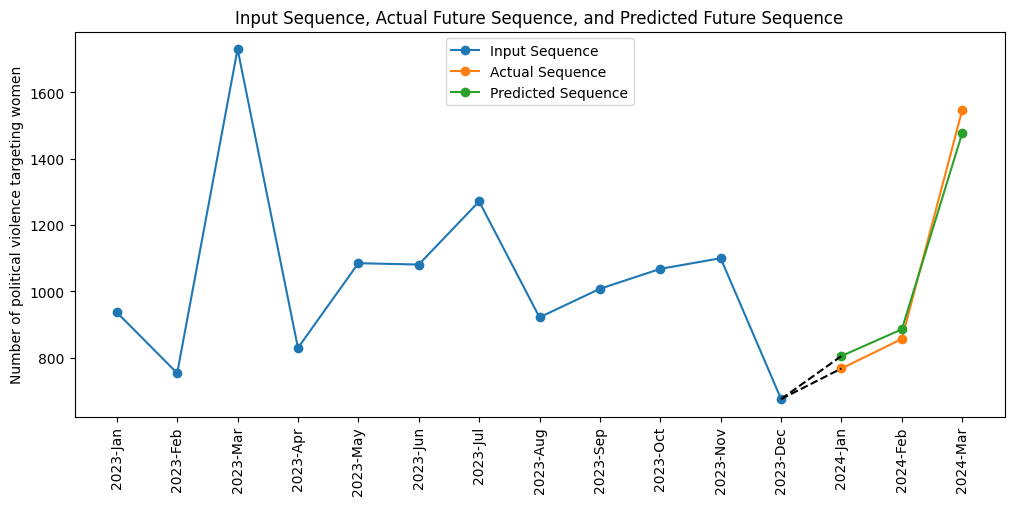

In [86]:
from matplotlib import pyplot as plt

# Plot the results
plt.figure(figsize=(12, 5))
index = 299
input_sequence = denormalized_result_df.iloc[index, :12]
actual_sequence = denormalized_result_df.iloc[index, 12:15]
predicted_sequence = denormalized_result_df.iloc[index, 15:]

# Plot input sequence
plt.plot(range(len(input_sequence)), input_sequence, label='Input Sequence', marker='o')

# Plot actual sequence
plt.plot(range(len(input_sequence), len(input_sequence) + len(actual_sequence)), actual_sequence, label='Actual Sequence', marker='o')

# Plot predicted sequence
plt.plot(range(len(input_sequence), len(input_sequence) + len(predicted_sequence)), predicted_sequence, label='Predicted Sequence', marker='o')

# Connect the end of the input sequence to the start of the actual sequence
plt.plot([len(input_sequence) - 1, len(input_sequence)], [input_sequence.iloc[-1], actual_sequence.iloc[0]], 'k--')

# Connect the end of the input sequence to the start of the predicted sequence
plt.plot([len(input_sequence) - 1, len(input_sequence)], [input_sequence.iloc[-1], predicted_sequence.iloc[0]], 'k--')

months = [
    '2023-Jan', '2023-Feb', '2023-Mar', '2023-Apr', '2023-May', '2023-Jun', 
    '2023-Jul', '2023-Aug', '2023-Sep', '2023-Oct', '2023-Nov', '2023-Dec',
    '2024-Jan', '2024-Feb', '2024-Mar'
]
data_length = len(months)


plt.ylabel('Number of political violence targeting women')
plt.xticks(ticks=np.arange(data_length), labels=months, rotation=90)
plt.title('Input Sequence, Actual Future Sequence, and Predicted Future Sequence')
plt.legend(loc='upper center')
plt.savefig('./imgs/vEvent.png', dpi=300)
plt.show()


Median of MSE errors: 72.21687155691129
Median of MAE errors: 7.679930927231906
Median of MSE errors: 1358.6690972796691
Median of MAE errors: 19.04572248164354


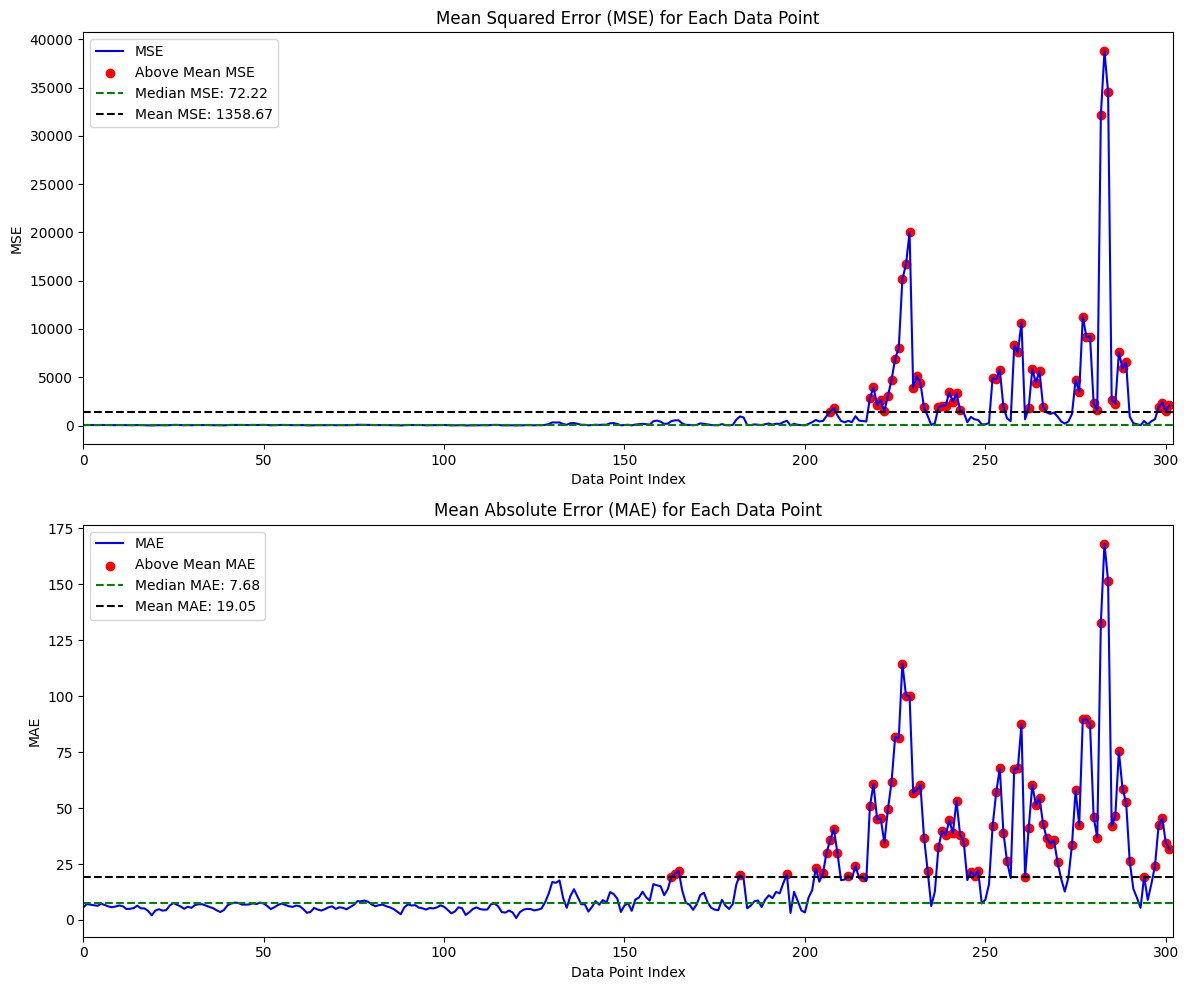

In [93]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'denormalized_result_df' contains the sequences as defined earlier
actual_sequences = denormalized_result_df.iloc[:, 12:15].values
predicted_sequences = denormalized_result_df.iloc[:, 15:].values

# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE) for each data point
mse_errors = np.array([mean_squared_error(a, p) for a, p in zip(actual_sequences, predicted_sequences)])
mae_errors = np.array([mean_absolute_error(a, p) for a, p in zip(actual_sequences, predicted_sequences)])

# Find the median of the MSE and MAE errors
median_mse = np.median(mse_errors)
median_mae = np.median(mae_errors)
print(f"Median of MSE errors: {median_mse}")
print(f"Median of MAE errors: {median_mae}")

# Find the median of the MSE and MAE errors
mean_mse = np.mean(mse_errors)
mean_mae = np.mean(mae_errors)
print(f"Median of MSE errors: {mean_mse}")
print(f"Median of MAE errors: {mean_mae}")

# Identify indices of MSE and MAE errors higher than the median
higher_than_median_mse_indices = np.where(mse_errors > median_mse)[0]
higher_than_median_mae_indices = np.where(mae_errors > median_mae)[0]

# Identify indices of MSE and MAE errors higher than the median
higher_than_mean_mse_indices = np.where(mse_errors > mean_mse)[0]
higher_than_mean_mae_indices = np.where(mae_errors > mean_mae)[0]

# Plot MSE and MAE for each data point
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(mse_errors, label='MSE', color='blue')
plt.scatter(higher_than_mean_mse_indices, mse_errors[higher_than_mean_mse_indices], color='red', label='Above Mean MSE')  # Highlight MSEs above median
plt.axhline(y=median_mse, color='green', linestyle='--', label=f'Median MSE: {median_mse:.2f}')  # Highlight the median MSE
plt.axhline(y=mean_mse, color='black', linestyle='--', label=f'Mean MSE: {mean_mse:.2f}')  # Highlight the median MAE

plt.title('Mean Squared Error (MSE) for Each Data Point')
plt.xlabel('Data Point Index')
plt.ylabel('MSE')
plt.xlim(0, len(mse_errors))
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(mae_errors, label='MAE', color='blue')
plt.scatter(higher_than_mean_mae_indices, mae_errors[higher_than_mean_mae_indices], color='red', label='Above Mean MAE')  # Highlight MAEs above median
plt.axhline(y=median_mae, color='green', linestyle='--', label=f'Median MAE: {median_mae:.2f}')  # Highlight the median MAE
plt.axhline(y=mean_mae, color='black', linestyle='--', label=f'Mean MAE: {mean_mae:.2f}')  # Highlight the median MAE

plt.title('Mean Absolute Error (MAE) for Each Data Point')
plt.xlim(0, len(mae_errors))
plt.xlabel('Data Point Index')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.savefig('./imgs/error_plot.png')
plt.show()

In [95]:
print(len(higher_than_mean_mse_indices), len(higher_than_mean_mae_indices))

56 83
